### Relatório

Perguntas dos stakeholders:
1. Quais são os fatores que mais influenciam o preço de fechamento das ações ao longo do tempo?
2. Existe alguma associação entre características setoriais/industriais e o desempenho das ações?
3. Como o volume de negociações e os dividendos distribuídos se comportam entre diferentes setores e ao longo do tempo?
4. O que pode ser feito para otimizar as vendas?


---
### Principais Relações Estatisticamente Significativas

A análise de correlação de Pearson revelou relações significativas entre os seguintes pares de variáveis:

* **Close** apresenta forte correlação com **High**, **Low** e **High**.

> Essas correlações indicam que os valores de abertura, máxima, mínima e fechamento tendem a variar de forma conjunta.

Foram identificadas associações relevantes entre variáveis numéricas e categorias do conjunto de dados, com base em testes de ANOVA:

* A variável **High** apresentou diferenças significativas entre **Tickers**, **Indústrias** e **Empresas**.
* A variável **Low** também variou de forma significativa entre **Tickers** e **Empresas**.
* O **EPS (USD)** apresentou variações significativas entre diferentes **Setores**.
* O **PE Ratio** e o **Day High (USD)** mostraram diferenças relevantes entre diferentes **Indústrias**.

Todas as correlações e padrões apresentados foram validados com o **uso de métodos de matematica** aplicada. Foram utilizadas técnicas de análise estatística para entender a relação entre variáveis, sempre com pesquisa para a interpretação dos dados.

Esse cuidado faz com que os **insights estejam embasados em evidências reais**. Dessa forma teremos uma **visão eficiente sobre o comportamento do mercado e suas tendências**.

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as pl
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import chi2_contingency
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import zscore


In [45]:
# Acessando o Drive que contém as bases de dados.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
df = pd.read_csv('/content/drive/MyDrive/Projeto Dados CITI (Squad Dani)/Databases/stock_data_merged.csv')

### 1. Quais são os fatores que mais influenciam o preço de fechamento das ações ao longo do tempo?

Nesta etapa, iremos explorar primeiramente os principais fatores de correlaçao com a variável close. Também iremos entender como é seu comportametno com o passar dos tempo e se há algum tipo de sazonalidade. Entender como é sua distribuição por cada empresa e entender tendências.

### Criando função de série temporal para plotar gráficos personalizados

In [47]:
# fragmentando a data para uma análise mais profunda
date_columns = ["Date", "Next Earnings Date"]

df[date_columns] = df[date_columns].apply(
    lambda col: pd.to_datetime(col, format="%d/%m/%Y", errors='coerce')
)

df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

# Plota série temporal de uma variável contínua com opções de agregação
def plot_time_series(df, variable, time_period='M', group_by=None, title=None):
    temp_df = df.copy()

    # Pular datas inválidas
    temp_df = temp_df[temp_df["Date"].notna()]

    # Criar coluna de período temporal
    if time_period == 'M':
        temp_df['Period'] = temp_df['Date'].dt.to_period("M").astype(str)
    elif time_period == 'Y':
        temp_df['Period'] = temp_df['Date'].dt.year.astype(str)
    else:
        raise ValueError("time_period deve ser 'M' ou 'Y'")

    # Agregar dados
    if group_by:
        aggregated = temp_df.groupby(['Period', group_by])[variable].mean().reset_index()
    else:
        aggregated = temp_df.groupby('Period')[variable].mean().reset_index()

    # Gerar título padrão se não fornecido
    if not title:
        title = f"Média de {variable} por {'Mês' if time_period=='M' else 'Ano'}"
        if group_by:
            title += f" e {group_by}"

    # Plotar
    if group_by:
        fig = px.line(aggregated, x='Period', y=variable, color=group_by, title=title)
    else:
        fig = px.line(aggregated, x='Period', y=variable, title=title)

    return fig


fig = plot_time_series(df, variable='Close', time_period='Y')
fig

O gráfico de série temporal acima representa o valor médio de fechamento das ações, no período de 2015 até a atualidade. Observa-se que a variação desse valor ao longo do tempo foi relativamente pequena, com uma diferença máxima de apenas 7 dólares.

Insights:

- A média observada em 2025 até o momento apresenta pouca expressividade em relação à máxima histórica.

- Nota-se também um leve aumento no valor médio de fechamento das empresas analisadas ao longo do tempo.

In [48]:
def plot_multiple_normalized_subplots(df, group_col, list_of_value_col_pairs):

    rows = (len(list_of_value_col_pairs) + 1) // 2  # número de linhas necessárias (2 por linha)
    cols = 2  # fixo: 2 por linha

    # Gerar títulos automaticamente
    titles = [f"{pair[0]} vs {pair[1]}" for pair in list_of_value_col_pairs]

    fig = make_subplots(rows=rows, cols=cols, subplot_titles=titles)

    for i, value_cols in enumerate(list_of_value_col_pairs):
        # Agrupar e normalizar
        grouped = df.groupby(group_col)[value_cols].mean().reset_index()
        normalized = grouped.copy()
        for col in value_cols:
            min_val = grouped[col].min()
            max_val = grouped[col].max()
            normalized[col] = (grouped[col] - min_val) / (max_val - min_val)

        # Long-form
        long_df = normalized.melt(id_vars=group_col, value_vars=value_cols,
                                  var_name="Variável", value_name="Valor Normalizado")

        # Subplot position
        row = i // 2 + 1
        col = i % 2 + 1

        # Adiciona linhas para cada variável
        for var in value_cols:
            data = long_df[long_df["Variável"] == var]
            fig.add_trace(go.Scatter(x=data[group_col], y=data["Valor Normalizado"],
                                     mode='lines+markers', name=var,
                                     legendgroup=var, showlegend=(i == 0)),
                          row=row, col=col)


    fig.show()

plot_multiple_normalized_subplots(
    df,
    group_col="Year",
    list_of_value_col_pairs=[
        ["Close", "High"],
        ["Close", "Low"],
        ["Close", "Open"],
        ["Close", "Adj Close"]
    ]
)


Os quatro gráficos representam a proporção da média da variável *Close* em cada ano, em comparação com outros fatores numéricos: *High*, *Low*, *Open* e *Adj Close*.

**Insights:**

* É evidente que *High*, *Low* e *Open* apresentam comportamentos proporcionais e semelhantes ao da variável *Close* ao longo do tempo.
* Isso reforça a importância de analisar os fatores que influenciam essas variáveis fortemente correlacionadas, como *Industry* e *Ticker*, evidenciando uma influência indireta, porém significativa, sobre o valor de *Close*.
* A variável *Adj Close* apresenta uma divergência considerável em relação ao valor de *Close*, o que pode indicar uma limitação na sua confiabilidade para análises diretas. Em contextos reais, espera-se que *Close* e *Adj Close* sejam muito próximos, o que levanta a hipótese de inconsistência.


$$
\text{Adjusted Close } = \text{Close - Dividend} \times \text{Adjustment Factor}
$$








### Entendendo média de gráfico com o Volume

In [49]:

fig1 = plot_time_series(df, variable='Close', time_period='Y', group_by='Sector')
fig2 = plot_time_series(df, variable='Volume', time_period='Y', group_by='Sector')

# Cria subplots lado a lado
combined_fig = make_subplots(rows=1, cols=2, subplot_titles=[fig1.layout.title.text, fig2.layout.title.text])

# Adiciona os dados do primeiro gráfico
for trace in fig1.data:
    combined_fig.add_trace(trace, row=1, col=1)

# Adiciona os dados do segundo gráfico
for trace in fig2.data:
    trace.showlegend = False
    combined_fig.add_trace(trace, row=1, col=2)

combined_fig.show()


As duas séries temporais representam o valor médio da variável Close ao longo dos anos da amostra, segmentado por Setores (que estão altamente correlacionados com Industry). Nos primeiros anos, observa-se uma variação significativa e relevante entre os setores.

Insights:

- Atualmente, o setor de Comunicação e Serviços apresenta uma queda acentuada tanto no volume quanto no valor médio de Close. Essa queda dupla pode indicar um período de retração ou até mesmo uma breve crise nesse segmento.

- O setor de Tecnologia atinge um pico próximo ao máximo histórico no valor médio de fechamento. Esse comportamento, aliado a outras evidências, pode indicar um possível crescimento acelerado, uma bolha de mercado, ou até mesmo uma oscilação normal, considerando que, em média, os valores também apresentaram aumentos pontuais ao longo do tempo.

### Compreendendo o comportamento de fechamento entre Tickers e industrias (no ano de 2024-2025)

In [50]:
def get_avg_bar_trace(df, val_col="Close", group_col="Ticker", year_min=2025, color_scale="Blues", cor=None, n_duble = False):
    if cor is None:
        cor = val_col

    # Filtrar
    filtrado = df[df["Year"] >= year_min]

    # Agrupar por média
    por_grupo_df = (
        filtrado
        .groupby(group_col)[val_col]
        .mean()
        .reset_index()
        .sort_values(by=val_col, ascending=False)
    )

    # Adicionar a coluna 'cor' ao dataframe agregado
    if cor != val_col:
        # Pegar primeiro valor da variável 'cor' para cada grupo
        valores_cor = (
            filtrado[[group_col, cor]]
            .drop_duplicates(subset=[group_col])
        )
        por_grupo_df = por_grupo_df.merge(valores_cor, on=group_col, how="left")

    # Criar gráfico
    fig_temp = px.bar(
        por_grupo_df,
        x=group_col,
        y=val_col,
        color=cor,
        color_continuous_scale=color_scale if pd.api.types.is_numeric_dtype(por_grupo_df[cor]) else None,
        color_discrete_sequence=px.colors.qualitative.Set2 if not pd.api.types.is_numeric_dtype(por_grupo_df[cor]) else None
    )
    if n_duble:

        return fig_temp
    return fig_temp.data, f"Média de {val_col} por {group_col}"


# Gerar os dados para Sector e Industry
traces1, title1 = get_avg_bar_trace(df, group_col="Ticker", year_min=2024, cor="Sector")
traces2, title2 = get_avg_bar_trace(df, group_col="Industry", year_min=2024, cor="Sector")

# Criar subplots com 2 colunas
fig = make_subplots(rows=1, cols=2, subplot_titles=[title1, title2])

# Adicionar os traces aos subplots
for trace in traces1:
    fig.add_trace(trace, row=1, col=1)

for trace in traces2:
    trace.showlegend = False
    fig.add_trace(trace, row=1, col=2)

# atualização para melhorar a visualização
fig.update_yaxes(range=[700, 810], row=1, col=1)
fig.update_yaxes(range=[600, 800], row=1, col=2)

# Layout final
fig.show()


Os gráficos acima mostram a média dos valores de fechamento, de 2024 até o momento atual, distribuídos por setor/indústria. Esse panorama revela diversos aspectos importantes em cada segmento.

* O Twitter apresenta uma média de fechamento substancialmente inferior às demais empresas analisadas. Esse dado reforça a necessidade de investigar a situação do setor de comunicações e serviços, podendo inclusive explicar a retração observada nesse ramo em 2025.

* O setor de tecnologia, além de concentrar o maior número de empresas, também apresenta as maiores médias de fechamento — com destaque para a Intuit Inc., que possui a média mais elevada entre todas. Esse cenário indica que o crescimento na média geral pode estar fortemente influenciado pelo bom desempenho das empresas de tecnologia.

### Conclusões sobre o comportamento dos fatores que mais influenciam o preço de fechamento das ações ao longo do tempo

O preço de fechamento das ações é influenciado por diversos fatores, tanto de forma direta quanto indireta. A análise temporal revela algumas dinâmicas importantes:

* Os valores diretamente correlacionados com o fechamento, como *High*, *Low* e *Close*, variam de forma distinta entre empresas, setores e indústrias. Embora estejam interligados, o comportamento dessas variáveis depende fortemente do contexto específico de cada grupo analisado.

* Em 2025, observou-se uma queda acentuada no valor de fechamento das ações do setor de comunicações e serviços. Essa retração impactou não apenas as variáveis diretamente ligadas ao fechamento, mas também outros indicadores gerais de desempenho do mercado.

* Historicamente, o setor de comunicações apresentou uma média de fechamento inferior ao esperado. Esse desempenho foi significativamente influenciado pelo baixo valor das ações do Twitter, que se destacaram negativamente dentro do grupo.

* A variável *Adj Close* apresentou comportamentos inconsistentes em alguns casos, sugerindo a presença de ruídos. Considerando que, em teoria, seu valor deveria ter uma correspondência linear com o *Close* , uma vez que é uma versão ajustada para eventos como dividendos e desdobramentos (essas divergências indicam a necessidade de investigação mais aprofundada sobre possíveis inconsistências nos dados ou nos ajustes aplicados).



# 2. Existe alguma associação entre características setoriais/industriais e o desempenho das ações?

Nesta etapa, buscamos identificar se existe alguma associação relevante entre os setores ou indústrias em que as empresas estão inseridas e o desempenho de suas ações, com base no Preço de Fechamento e na Capitalização de Mercado (Market Cap). Para isso, analisamos os setores mais representativos da amostra e verificamos as médias de desempenho dessas categorias.

O desempenho das ações é influenciado por diversas variáveis, muitas das quais já foram analisadas em detalhes anteriormente. Compreender esse fator é essencial para entender o comportamento do mercado de forma abrangente.


### Gerando visualizações das principais variáveis que podem influenciar o desempenho das ações entre setor/industria

<ipython-input-51-e0716ec2d756>:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




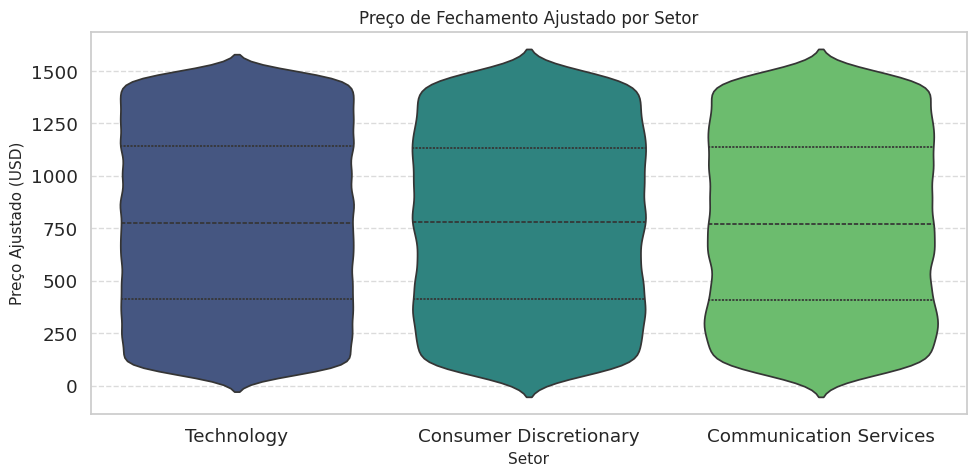

<ipython-input-51-e0716ec2d756>:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




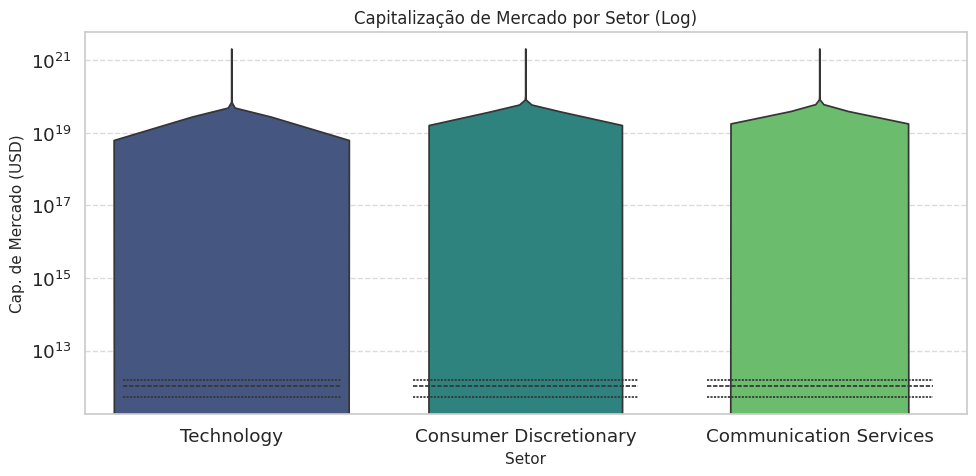

<ipython-input-51-e0716ec2d756>:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




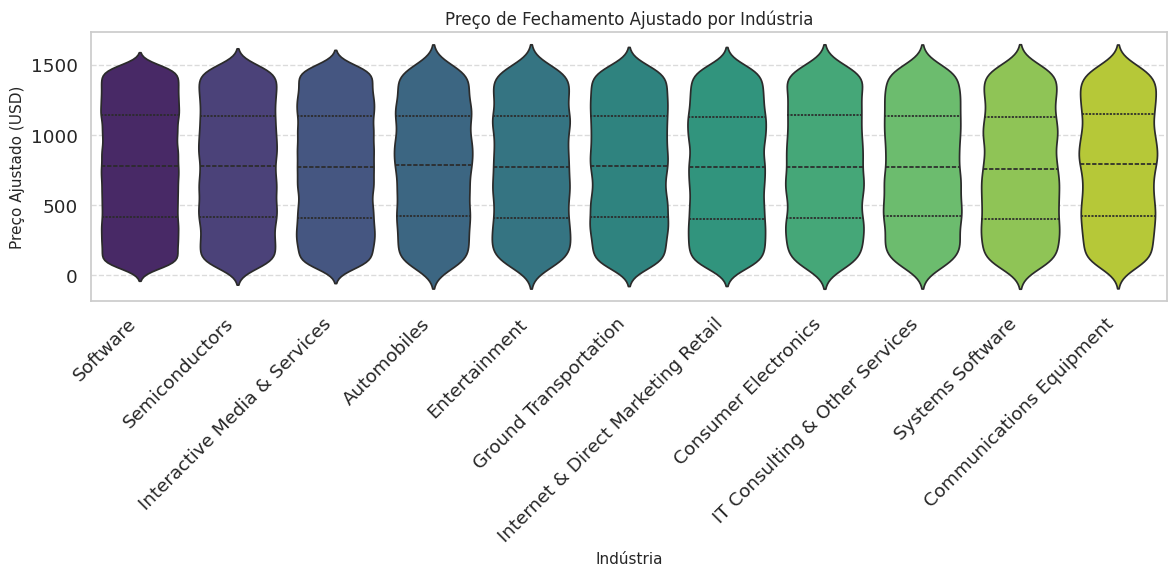

<ipython-input-51-e0716ec2d756>:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




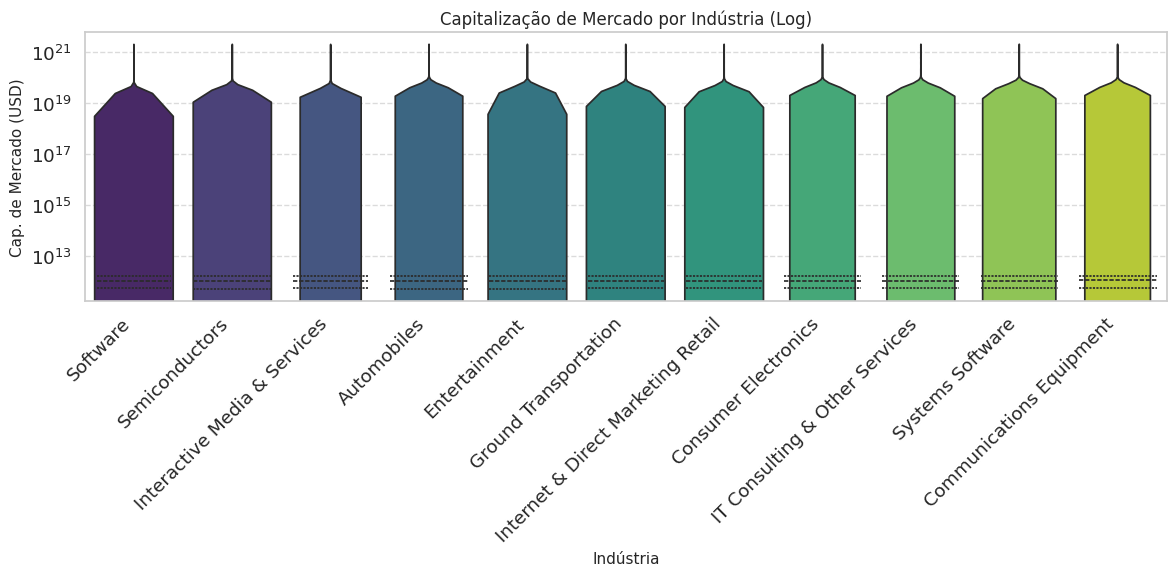

In [51]:
df_plot = df.dropna(subset=['Adj Close', 'Market Cap (USD)', 'Sector', 'Industry']).copy()
top_sectors = df_plot['Sector'].value_counts().nlargest(3).index
df_plot_filtered = df_plot[df_plot['Sector'].isin(top_sectors)]
unique_industries = df_plot['Industry'].unique()

# Estilo e paletas
sns.set(style="whitegrid", context="notebook", font_scale=1.2)
palette_sector = sns.color_palette("viridis", len(top_sectors))
palette_industry = sns.color_palette("viridis", len(unique_industries))

# Função para gerar violinplots
def plot_violin(x, y, data, palette, title, xlabel, ylabel, log_scale=False, rotate_xticks=False, fig_size=(10,5)):
    plt.figure(figsize=fig_size)
    sns.violinplot(x=x, y=y, data=data, inner='quartile', palette=palette)
    plt.title(title, fontsize=12)
    plt.xlabel(xlabel, fontsize=11)
    plt.ylabel(ylabel, fontsize=11)
    if log_scale:
        plt.yscale('log')
    if rotate_xticks:
        plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Gráficos
plot_violin(
    x='Sector', y='Adj Close', data=df_plot_filtered, palette=palette_sector,
    title='Preço de Fechamento Ajustado por Setor',
    xlabel='Setor', ylabel='Preço Ajustado (USD)'
)

plot_violin(
    x='Sector', y='Market Cap (USD)', data=df_plot_filtered, palette=palette_sector,
    title='Capitalização de Mercado por Setor (Log)',
    xlabel='Setor', ylabel='Cap. de Mercado (USD)',
    log_scale=True
)

plot_violin(
    x='Industry', y='Adj Close', data=df_plot, palette=palette_industry,
    title='Preço de Fechamento Ajustado por Indústria',
    xlabel='Indústria', ylabel='Preço Ajustado (USD)',
    rotate_xticks=True, fig_size=(12,6)
)

plot_violin(
    x='Industry', y='Market Cap (USD)', data=df_plot, palette=palette_industry,
    title='Capitalização de Mercado por Indústria (Log)',
    xlabel='Indústria', ylabel='Cap. de Mercado (USD)',
    log_scale=True, rotate_xticks=True, fig_size=(12,6)
)

Com base na análise visual dos gráficos de distribuição para as métricas de desempenho das ações (Adj Close e Market Cap) em relação aos Setores e Indústrias, a resposta é:

**Não**, a análise dos dados não revela uma associação forte ou uma dependência significativa entre as características setoriais/industriais e o desempenho "típico" das ações.

---

**Detalhamento e Obsevações:**


**Preço de Fechamento Ajustado (Adj Close):** Homogeneidade Clara

- Tanto nos gráficos por Setor quanto por Indústria (Gráficos 1 e 3), as formas dos "violinos" são notavelmente semelhantes. Isso indica que o preço "típico" das ações e a forma como esses preços se espalham são muito consistentes e homogêneos entre diferentes setores e indústrias. Não há um grupo que se destaque significativamente por ter ações fundamentalmente mais caras ou mais baratas que os outros.

**Capitalização de Mercado (Market Cap - USD):** Tamanho Típico Similar, mas com Gigantes Universais

- Nos gráficos de Market Cap (Gráficos 2 e 4), observe que a parte maior de cada violino (representando a maioria das empresas) está posicionada em uma altura muito similar, tanto por setor quanto por indústria. Isso sugere que o valor de mercado "típico" das empresas é bastante parecido, independentemente do grupo ao qual pertencem.
No entanto, todos os violinos apresentam alongamentos longos e finas que se estendem para valores de Market Cap extremamente altos. Isso demonstra que a presença de poucas empresas com capitalizações de mercado gigantescas é uma característica universal no conjunto de dados, aparecendo em praticamente todos os setores e indústrias, e não é um traço exclusivo ou diferenciador de um grupo específico.


**Outras Métricas (PE Ratio e EPS):**

- Embora não ilustrado por gráficos adicionais para manter a concisão, análises anteriores mostraram que PE Ratio e EPS (USD) também apresentam padrões de distribuição muito homogêneos entre setores e indústrias, reforçando a falta de uma associação distintiva.

---

Em suma, as métricas de desempenho das ações analisadas (Adj Close, Market Cap, PE Ratio, EPS) demonstraram um comportamento consistentemente homogêneo em suas distribuições e tendências centrais entre os diferentes setores e indústrias. Isso sugere que, para este conjunto de dados, as características setoriais ou industriais não são um fator primário que explique grandes variações no desempenho "típico" das ações.

### Checando relação de O EPS (USD) e Setores
O teste de ANOVA destacou uma correlação forte entre essas duas variaveis.

$$
\text{EPS} = \frac{\text{Lucro Líquido} - \text{Dividendos Preferenciais}}{\text{Número de Ações Ordinárias em Circulação}}
$$

EPS é de extrema importancia para compreender o desempenho de uma ação.

In [52]:
plot_time_series(df, variable='EPS (USD)', time_period='Y', group_by='Sector', title="EPS Médio Anual por Setor")


O gráfico acima apresenta o valor médio do EPS ao longo dos anos. Observa-se uma variação discreta, porém relevante.

- O setor de tecnologia demonstra uma consistência notável, com pouca variação nos últimos anos, o que pode indicar estabilidade importante para decisões de investimento.

- Em contraste, os setores de comunicação (Communication Services) e consumo discricionário (Consumer Discretionary) apresentam maior volatilidade.

- Esse padrão está alinhado com diversas análises anteriores, indicando que a maioria das empresas na amostra pertence ao setor de tecnologia, o que contribui para variações menos expressivas em determinados períodos. A maior discrepancia no ano atual também pode ser explicada pelo menor numero de valores medidos.

### Compreendendo a relação entre PE Ratio e Industry

**PE Ratio** (Price-to-Earnings Ratio) é a relação entre o preço da ação de uma empresa e seu lucro por ação (EPS). Ele mostra quantos dólares os investidores estão dispostos a pagar por cada dólar de lucro da empresa.

$$
\text{PE Ratio} = \frac{\text{Preço da ação}}{\text{Lucro por ação (EPS)}}
$$


Mais uma variável importante, derivada do EPS

In [53]:
title= get_avg_bar_trace(df, "PE Ratio", "Industry", cor="Sector", n_duble=True, year_min=2024)

title


O gráfico de barras demosntra o valor médio de PE Ratio em cada industria de 2024 para ca. Suas cores representam os setores. Percebe-se que de forma geral a variação é breve, etretanto não pode ser ignorada, considerando o tamanho da amostra.
- Percebe-se que os valores que deveriam entre EPS PE ratio não tem correlação inversa clara (o que deveria acontecer, pois são inversamente proporcionais)

# 3. Como o volume de negociações e os dividendos se comportam entre diferentes setores e ao longo do tempo?

Nesta etapa, buscamos entender como o comportamento dos investidores e a política de distribuição de lucros variam entre os principais setores do mercado. Focamos em três setores predominantes no conjunto de dados: Tecnologia, Consumo Discricionário e Serviços de Comunicação.

Dividendo representa a parte do lucro que uma empresa distribui aos seus acionistas; um dividendo saudável varia conforme o setor, mas geralmente indica estabilidade financeira e costuma ficar entre 2% e 6% ao ano (dividend yield).
Volume representa a quantidade de ações negociadas em um período; volumes mais altos costumam indicar maior liquidez, o que facilita a compra e venda de ações com menor variação de preço, mas não indicam necessariamente qualidade do ativo.



### Criando a nova coluna Dividend Yield:
Para avaliar melhor a atratividade dos dividendos pagos pelas empresas listadas no dataset, foi criada uma nova coluna chamada `Dividend Yield`.

Enquanto a coluna `Dividend` informa apenas o valor absoluto distribuído por ação, ela não considera o preço da ação no momento do pagamento. Por isso, para fins comparativos entre empresas e setores, o mais adequado é utilizar o **Dividend Yield (DY)** — que representa a relação percentual entre o dividendo pago e o preço da ação.


$$
{Dividend Yield} = \left( \frac{\text{Dividend}}{\text{Close}} \right) \times 100
$$

Esse indicador permite identificar, proporcionalmente, quais empresas estão gerando maior retorno em forma de dividendos sobre o valor investido. Empresas com Dividend Yields muito baixos tendem a reinvestir seus lucros (como é comum no setor de tecnologia), enquanto aquelas com Dividend Yields elevados geralmente operam em setores mais estáveis e maduros, com foco em remuneração dos acionistas.



In [54]:
DivYeald = (df["Dividend"] / df["Close"]) * 100


print(DivYeald.describe())

quantil_95 = DivYeald.quantile(0.95)
print(f"Quantil 95% do Dividend Yield: {quantil_95:.2f}%")

count    200000.000000
mean          0.427592
std           0.453168
min           0.000000
25%           0.161144
50%           0.323094
75%           0.529317
max           9.104820
dtype: float64
Quantil 95% do Dividend Yield: 1.19%


A tabela revela que os valores de *Dividend Yield* estão extremamente abaixo do intervalo considerado desejável (entre 2% e 6%). Cerca de 95% das observações apresentam valores inferiores a 1,2%, o que pode indicar a presença de **ruído nos dados** ou problemas na coleta ou cálculo dessa métrica.

Além disso, *Dividend Yields* baixos costumam ser característicos de empresas em **fase de crescimento acelerado**, que optam por reinvestir seus lucros em vez de distribuí-los. No entanto, esse não parece ser o perfil predominante entre as empresas analisadas, o que reforça a hipótese de inconsistência ou distorção nos dados.

### Comportamento e distribuição de Volume e dividendos em cada setor (panorama geral)

In [55]:
 # Plota um gráfico Sunburst com base na hierarquia fornecida, agregando por uma variável numérica.
def plot_sunburst_by_hierarchy(df, value_col, year_filter=None,
                                hierarchy=['Sector', 'Industry', 'Ticker'],
                                title=None, use_mean=True):
    temp_df = df.copy()

    # Aplicar filtro de ano, se fornecido
    if year_filter is not None:
        temp_df = temp_df[temp_df["Year"] >= year_filter]

    # Agregar (média ou soma)
    if use_mean:
        df_agg = temp_df.groupby(hierarchy)[value_col].mean().reset_index()
    else:
        df_agg = temp_df.groupby(hierarchy)[value_col].sum().reset_index()

    # Plotar
    fig = px.sunburst(
        df_agg,
        path=hierarchy,
        values=value_col,
        branchvalues='total',
        hover_data={value_col: ':.2f'},
        labels={value_col: value_col},
        title=title
    )

    fig.update_layout(margin=dict(t=40, l=0, r=0, b=0))
    fig.show()


plot_sunburst_by_hierarchy(
    df,
    value_col="Volume",
    year_filter=2024,
    title="Preço Volume por Setor/Indústria/Ticker (2024+)", use_mean=True
)
plot_sunburst_by_hierarchy(
    df,
    value_col="Dividend",
    year_filter=2024,
    title="Preço de Dividendo por Setor/Indústria/Ticker (2024+)", use_mean=True
)

Os dois gráficos interativos (pode-se clicar em um setor ou industria especifico para analisar mais de perto) do tipo raio de sol demonstra a distribição das variaveis em cada fator. É evidente a semelhança da distribuição tando de dividendo quanto de volume.

- O comportamento de distribuição da proporção entre dividendo e volume segue certa semelhança.
- A visão geral também demosntra que a maioria das empresas analisadas são de tecnologia (dois terços).


### Compreendendo o comportamento das variáveis em cada ano em cada setor

In [56]:

fig1 = plot_time_series(df, variable='Volume', time_period='Y', group_by='Sector')
fig2 = plot_time_series(df, variable='Dividend', time_period='Y', group_by='Sector')

# Cria subplots lado a lado
combined_fig = make_subplots(rows=1, cols=2, subplot_titles=[fig1.layout.title.text, fig2.layout.title.text])

# Adiciona os dados do primeiro gráfico
for trace in fig1.data:
    combined_fig.add_trace(trace, row=1, col=1)

# Adiciona os dados do segundo gráfico
for trace in fig2.data:
    trace.showlegend = False
    combined_fig.add_trace(trace, row=1, col=2)

combined_fig.show()

As duas séries temporais mostram a variação dos valores ao longo dos anos. Como já mencionado, o volume no setor de comunicações e serviços apresentou uma queda brusca de 2024 para 2025.

* O valor absoluto do dividendo bruto, isoladamente, tem pouco significado real; quando considerado em relação ao preço de fechamento, um valor maior indica melhor retorno para o investidor.
* O setor de tecnologia parece mais estável, o que pode ser explicado pelo desequilíbrio na distribuição de dividendos entre os setores.


### Volume em cada empresa de 2024 até a atualidade

In [57]:
fig = get_avg_bar_trace(df, "Volume", "Ticker", cor="Sector", n_duble=True, year_min=2024)
fig.update_layout(yaxis_range=[4.5*10**9, 5.3*10**9]) # mhlhorando a visualização dos detalhes

O gráfico de barras demonstra a diferença de volumes em média do volume em cada empresa.

- Nvidia é a que apresenta maior volume. Isso pode indicar um aumento da liquidez das ações. O que na maioria dos casos represnta um sintoma bom para a empresa.

### 4. O que pode ser feito para otimizar as vendas?

Para responder essa pergunta, é fundamental entender e mensurar diversos parâmetros já analisados no df. Otimizar vendas não se resume apenas a aumentar a quantidade de negociações (volume), mas sim a melhorar a eficiência e o valor, considerando fatores que impactam a atratividade e liquidez dos ativos. Ou seja, está ligado a Saúde completa da empresa, entender seus pontos negativos e positivos em relação ao mercado.

**Otimizar vendas significa apenas aumentar o volume?**

Nem sempre, vender mais ações não significa otimizar. No mercado financeiro, aumentar o volume de negociações pode ser um indicador positivo, pois sugere maior liquidez e facilidade para comprar e vender ações. Assim, otimizar vendas é uma combinação de aumentar volume, melhorar preço e qualidade das negociações, além de garantir estabilidade e confiança no mercado.



### Entendendo o posicionamento em relação ao mercado de cada empresa

* Será criada uma nova tabela que diagnostica cada empresa individualmente com base em dados históricos.
* A análise considera métricas como crescimento de preço, dividendos, volume de negociação, valor de mercado, P/E ratio e volatilidade.
* Cada métrica recebe um peso específico, definido de forma arbitrária, mas fundamentado em práticas de mercado e indicadores reconhecidos.
* As métricas são padronizadas (z-score) e escaladas para uma faixa percentual (0–100), refletindo a posição relativa de cada empresa dentro da amostra.
* O "Health Score" final representa o desempenho relativo da empresa, e não uma indicação direta de saúde financeira absoluta.
* Empresas com escores baixos não estão necessariamente em má situação, apenas ocupam posições inferiores em relação às demais da amostra.
* A função identifica o ponto forte e fraco de cada empresa com base nas métricas mais e menos favoráveis.
* Também são gerados alertas para destacar aspectos importantes, como alta volatilidade, baixo crescimento ou dividendos extremos.


### Tabela de ranking de pontuação de cada empresa

In [58]:
def calcular_saude_empresa(df, pesos=None, plot=False):

    if pesos is None:
        pesos = {
            'crescimento': 0.35,
            'dividendo': 0.20,
            'volume': 0.20,
            'market_cap': 0.15,
            'pe_ratio': 0.15,
            'volatilidade': 0.05
        }

    df_sorted = df.sort_values(by=['Company', 'Date']).copy()
    df_sorted['Ano'] = pd.to_datetime(df_sorted['Date']).dt.year

    resultados_raw = []

    for company, grupo in df_sorted.groupby('Company'):
        try:
            ano_inicio = grupo['Ano'].min()
            ano_fim = grupo['Ano'].max()
            media_inicio = grupo[grupo['Ano'] == ano_inicio]['Close'].mean()
            media_fim = grupo[grupo['Ano'] == ano_fim]['Close'].mean()
            crescimento = (media_fim - media_inicio) / media_inicio if media_inicio != 0 else 0
        except:
            crescimento = 0

        volatilidade = np.mean(grupo['High'] - grupo['Low']) / grupo['Open'].mean() if grupo['Open'].mean() != 0 else 0
        dividendo = grupo['Dividend'].mean()
        volume = grupo['Volume'].mean()
        market_cap = grupo['Market Cap (USD)'].mean()
        pe = grupo['PE Ratio'].mean()
        pe_desvio = abs(pe - 20)

        resultados_raw.append({
            'Company': company,
            'Crescimento': crescimento,
            'Volatilidade': 1 - volatilidade,
            'Dividendo': dividendo,
            'Volume': volume,
            'Market Cap': market_cap,
            'PE Ratio Score': 1 - (pe_desvio / 40),
            'Sector': grupo['Sector'].iloc[0],
            'Industry': grupo['Industry'].iloc[0]
        })


    df_metricas = pd.DataFrame(resultados_raw).set_index('Company')

    # Padronização com z-score (algumas métricas têm direção invertida)
    for col in df_metricas.columns:
        if col in ['Sector', 'Industry']:
          continue
        if col in ['Volatilidade', 'PE Ratio Score']:  # já são "melhor quanto maior"
            df_metricas[col + '_z'] = zscore(df_metricas[col].fillna(0))
        else:
            df_metricas[col + '_z'] = zscore(df_metricas[col].fillna(0))

    # Escalonar z-scores para uma faixa 0–100 (usando percentis)
    df_scaled = df_metricas[[c for c in df_metricas.columns if c.endswith('_z')]].copy()
    df_scaled = df_scaled.apply(lambda x: 100 * (x.rank(pct=True)))

    # Score final ponderado
    df_scaled['Health Score'] = (
        df_scaled['Crescimento_z'] * pesos['crescimento'] +
        df_scaled['Dividendo_z'] * pesos['dividendo'] +
        df_scaled['Volume_z'] * pesos['volume'] +
        df_scaled['Market Cap_z'] * pesos['market_cap'] +
        df_scaled['PE Ratio Score_z'] * pesos['pe_ratio'] +
        df_scaled['Volatilidade_z'] * pesos['volatilidade']
    )

    # Pontos fortes e fracos
    metricas_reais = ['Crescimento', 'Dividendo', 'Volume', 'Market Cap', 'PE Ratio Score', 'Volatilidade']
    df_metricas['Health Score'] = df_scaled['Health Score']
    df_metricas['Ponto Forte'] = df_scaled[[
        m + '_z' for m in metricas_reais
    ]].idxmax(axis=1).str.replace('_z', '')
    df_metricas['Ponto Fraco'] = df_scaled[[
        m + '_z' for m in metricas_reais
    ]].idxmin(axis=1).str.replace('_z', '')

    # Gerar alertas
    def gerar_alertas(company):
        alertas = []

        if company in df_scaled['Crescimento_z'].nlargest(10).index:
            alertas.append('Crescimento entre os 10 maiores')
        elif company in df_scaled['Crescimento_z'].nsmallest(10).index:
            alertas.append('Crescimento entre os 10 menores')

        if company in df_scaled['Volatilidade_z'].nsmallest(10).index:
            alertas.append('Volatilidade entre as 10 maiores')

        if company in df_scaled['PE Ratio Score_z'].nsmallest(10).index:
            alertas.append('P/E Score entre os 10 piores')

        if company in df_scaled['Dividendo_z'].nlargest(10).index:
            alertas.append('Dividendos entre os 10 maiores')
        elif company in df_scaled['Dividendo_z'].nsmallest(10).index:
            alertas.append('Dividendos entre os 10 menores')

        if company in df_scaled['Volume_z'].nlargest(10).index:
            alertas.append('Volume entre os 10 maiores')
        elif company in df_scaled['Volume_z'].nsmallest(10).index:
            alertas.append('Volume entre os 10 menores')

        if company in df_scaled['Market Cap_z'].nlargest(10).index:
            alertas.append('Market Cap entre os 10 maiores')
        elif company in df_scaled['Market Cap_z'].nsmallest(10).index:
            alertas.append('Market Cap entre os 10 menores')

        return ', '.join(alertas) if alertas else 'OK'

    df_metricas['Alertas'] = df_metricas.index.map(gerar_alertas)

    # Distribuição
    if plot:
        df_metricas['Health Score'].hist(bins=50)
        plt.title('Distribuição dos Health Scores')
        plt.xlabel('Health Score')
        plt.ylabel('Nº de Empresas')
        plt.show()

    return df_metricas[['Health Score', 'Ponto Forte', 'Ponto Fraco', 'Alertas', 'Sector', 'Industry']].sort_values(by='Health Score', ascending=False).reset_index()




# Execução:
resultado = calcular_saude_empresa(df)
resultado["Health Score"] = resultado["Health Score"].round(2)
resultado

,Company,Health Score,Ponto Forte,Ponto Fraco,Alertas,Sector,Industry
0,Intel Corporation,92.67,Crescimento,Volatilidade,"Crescimento entre os 10 maiores, Dividendos en...",Technology,Semiconductors
1,"VMware, Inc.",87.17,Market Cap,Volatilidade,"Volatilidade entre as 10 maiores, Dividendos e...",Technology,Systems Software
2,"DocuSign, Inc.",83.33,Volatilidade,Market Cap,"Crescimento entre os 10 maiores, Dividendos en...",Technology,Software
3,International Business Machines,75.67,Dividendo,Crescimento,"Dividendos entre os 10 maiores, Volume entre o...",Technology,IT Consulting & Other Services
4,Snap Inc.,74.33,Dividendo,Market Cap,"Dividendos entre os 10 maiores, Volume entre o...",Communication Services,Interactive Media & Services
5,"Twitter, Inc.",73.33,PE Ratio Score,Volatilidade,"Volatilidade entre as 10 maiores, Dividendos e...",Communication Services,Interactive Media & Services
6,Intuit Inc.,73.00,Crescimento,Market Cap,"Crescimento entre os 10 maiores, P/E Score ent...",Technology,Software
7,Oracle Corporation,71.00,Volume,Crescimento,"Volume entre os 10 maiores, Market Cap entre o...",Technology,Software
8,"Lyft, Inc.",65.33,Volume,Volatilidade,"Crescimento entre os 10 menores, Volatilidade ...",Consumer Discretionary,Ground Transportation
9,"Block, Inc.",63.50,Market Cap,Dividendo,"Crescimento entre os 10 maiores, Dividendos en...",Technology,Software




A tabela de diagnostico apresenta uma empresa analisada por linha e descreve de forma geral o posicionamento em relação as outras. Os pontos fortes e pontos fracos ajudam a compreender de forma. Já os alertas auxiliam na investigação posicional destacando caso ela tenha tanto um valor mais alto que as demais ou mais baixo. Tudo isso faz a análise ser plurilateral e bastante investigativo, aspectos importates para responder a pergunta proposta

- A empresa que obteve o maior escore foi a Intel, com crescimento como ponto forte e volatilidade como fraco. Esse comportamento é comum para empresas desse setor.
- Agora é possivel ver de forma mais profunda cada empresa porque as diferenças são a chave da avaliação feita.


### Saúde média por escore de saúde

In [59]:
grouped = resultado.groupby('Sector')["Health Score"].mean().reset_index().sort_values(by='Health Score', ascending=False)

fig = px.bar(grouped, x='Sector', y='Health Score', title='Média de Health Score por Setor', color='Sector', )
fig.update_layout(
    xaxis_title='Setor',
    yaxis_title='Média de Health Score',
    yaxis=dict(range=[50, 60])
)
fig.show()

In [60]:
# Seleciona os extremos
top15    = resultado.nlargest(15, "Health Score")
bottom15 = resultado.nsmallest(15, "Health Score")

# Conta pontos fortes / fracos em cada grupo
fortes_top     = top15["Ponto Forte"].value_counts().reset_index()
fracos_top     = top15["Ponto Fraco"].value_counts().reset_index()
fortes_bottom  = bottom15["Ponto Forte"].value_counts().reset_index()
fracos_bottom  = bottom15["Ponto Fraco"].value_counts().reset_index()

for i in [fortes_top, fracos_top, fortes_bottom, fracos_bottom]:
    i.columns = ["Categoria", "Contagem"]

# Cria grade 2×2 de gráficos de pizza
fig = make_subplots(
    rows=2, cols=2, specs=[[{"type": "domain"}, {"type": "domain"}],
                           [{"type": "domain"}, {"type": "domain"}]],
    subplot_titles=[
        "Pontos Fortes – Top 15",   "Pontos Fracos – Top 15",
        "Pontos Fortes – Bottom 15", "Pontos Fracos – Bottom 15"
    ]
)

fig.add_trace(go.Pie(labels=fortes_top["Categoria"],
                     values=fortes_top["Contagem"],
                     name="Fortes (Top 15)"),
              row=1, col=1)

fig.add_trace(go.Pie(labels=fracos_top["Categoria"],
                     values=fracos_top["Contagem"],
                     name="Fracos (Top 15)"),
              row=1, col=2)

fig.add_trace(go.Pie(labels=fortes_bottom["Categoria"],
                     values=fortes_bottom["Contagem"],
                     name="Fortes (Bottom 15)"),
              row=2, col=1)

fig.add_trace(go.Pie(labels=fracos_bottom["Categoria"],
                     values=fracos_bottom["Contagem"],
                     name="Fracos (Bottom 15)"),
              row=2, col=2)

fig.update_layout(
    title_text="Top 15 vs Bottom 15 • Distribuição de Pontos Fortes e Fracos",
    height=700,
    showlegend=False
)

fig.show()


Principais Insights com base nos gráficos setoriais

* **Crescimento como fator dominante no top 15:**
  O fator *Crescimento* aparece com alta frequência entre as empresas com melhor desempenho, sendo o mais recorrente em 3 dos 4 gráficos. Isso reforça a ideia de que empresas com crescimento sólido e contínuo tendem a entregar melhores retornos ajustados ao risco. Essa variável merece maior peso no processo de avaliação de ações.

* **Market Cap como critério de segurança:**
  Empresas com maior *Market Cap* aparecem em boa posição nos dois extremos, o que pode indicar que empresas consolidadas nem sempre performam bem, mas costumam ter menor risco estrutural. Portanto, deve-se avaliar o *Market Cap* em conjunto com outras variáveis — por si só, ele não garante desempenho, mas pode oferecer resiliência em períodos instáveis.

* **Dividendos não são exclusivos de empresas sólidas:**
  A variável *Dividendo* aparece tanto entre boas quanto más pontuações, o que sugere que pagar dividendos não necessariamente significa boa saúde financeira ou potencial de valorização. Em alguns casos, pode até indicar estagnação, com distribuição de lucros por falta de novos investimentos. Assim, o *Dividend Yield* deve ser interpretado com cuidado e dentro do contexto do setor e da estratégia da empresa.

* **Volume como indicador de liquidez e confiança:**
  O *Volume* aparece com destaque nas empresas com piores pontuações, o que pode parecer contraintuitivo. No entanto, isso pode estar relacionado a movimentos especulativos, onde empresas com fundamentos fracos recebem muita atenção de curto prazo. Logo, alto volume deve ser analisado junto à qualidade dos fundamentos da empresa, e não isoladamente.

* **PE Ratio Score como critério complementar:**
  A pontuação baseada no *PE Ratio* aparece em baixa frequência em todos os quadrantes, o que indica que esse indicador não é, por si só, um fator determinante nas classificações finais. No entanto, ele continua útil como uma medida complementar de avaliação de preço em relação aos lucros.





## Plano de Ação

Com base nas análises realizadas, a C3 deve adotar medidas estratégicas para aprimorar suas decisões relacionadas à compra e venda de ações, bem como à avaliação comportamental das empresas.

Em primeiro lugar, é essencial acompanhar o histórico de preços de fechamento das empresas, analisando não apenas o desempenho individual de cada uma, mas também o comportamento de outras empresas dentro do mesmo setor. O ramo de atuação pode refletir padrões de mercado, tendências e até disfarçar bolhas de crescimento que não representam evolução sustentável.

Observou-se também uma certa estabilidade no valor médio de fechamento das ações ao longo dos anos entre as empresas analisadas. Isso sugere um cenário de investimento relativamente sólido, com menor risco se comparado, por exemplo, a startups. No entanto, é fundamental estar atento às pequenas variações de mercado. Para isso, o diagnóstico apresentado ajuda a destacar os pontos fortes e fracos de cada empresa, além de fornecer alertas relevantes.

O volume de negociação, embora não reflita diretamente a saúde financeira de uma empresa, é uma variável essencial para captar tendências de mercado, identificar interesse dos investidores e avaliar a liquidez dos ativos.

Além disso, destaca-se que o setor de tecnologia demonstrou consistência e desempenho superior em vários indicadores analisados, o que indica que investir nesse setor pode ser uma estratégia sólida no médio e longo prazo. Em contraste, o setor de comunicação (menor pontuação no diagnóstico) apresentou queda recente tanto nos preços de fechamento quanto no volume negociado, sinalizando uma diminuição na liquidez.

Como estratégia, recomenda-se alocar uma parcela maior do capital em empresas que obtiveram boa pontuação no diagnóstico (como Intel, VMware, Inc. e DocuSign, Inc.), pois há indícios de que essas apresentam maior potencial de valorização e menor risco ao longo do tempo.

Diante das análises realizadas, é fundamental atribuir maior peso a empresas com histórico comprovado de crescimento real. Quando o risco não é um fator restritivo, níveis controlados de volatilidade podem ser aceitáveis, desde que sustentados por um padrão consistente de crescimento ao longo do tempo.

Por fim, diversificar os investimentos entre diferentes setores se mostra uma estratégia prudente, pois reduz a exposição a bolhas setoriais ou recessões inesperadas, contribuindo para um portfólio mais resiliente e equilibrado.


### Plano para o Futuro

Com base nos resultados obtidos, propõem-se os seguintes aprimoramentos para fortalecer a capacidade analítica da C3 e apoiar decisões de investimento mais precisas:

* **Aprimorar engenharia de coleta de informações:** Reestruturar o processo de coleta, tratamento e segmentação dos dados, a fim de garantir maior qualidade, precisão e utilidade nas análises.

* **Aprimorar a função de diagnóstico:**  expandir o modelo atual, incorporando novos indicadores financeiros, comportamentais e setoriais para uma avaliação mais robusta das empresas.

* **Desenvolver uma API de consulta rápida:** Criar uma interface de programação que permita acesso ágil e estruturado às análises e métricas geradas, facilitando a integração com outras ferramentas internas ou externas.

* **Construir um dashboard interativo integrado:** Implementar uma interface visual que reúna indicadores-chave, gráficos comparativos e alertas automatizados, tornando a interpretação dos dados mais intuitiva e dinâmica.

* **Prever fatores-chave de impacto:** Desenvolver modelos preditivos capazes de antecipar variações relevantes no preço de fechamento e em outros indicadores com base em tendências históricas e sinais do mercado.
